In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from scipy.signal import cwt, ricker
%matplotlib inline

In [2]:
gan_index = [100, 101, 102, 103, 500, 501, 502, 503]
gan_ds = {}
for gi in gan_index:
    gan_ds[gi] = xr.open_dataset(f"/glade/work/dgagne/exp_20_stoch/gan_{gi}_climate/02000000/lorenz_forecast_02000000_00.nc")


In [3]:
poly = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/poly_add_climate/02000000/lorenz_forecast_02000000_00.nc")

In [4]:
truth = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/lorenz_output.nc")

In [ ]:
/glade/work/dgagne/exp_20_stoch/

In [4]:
ls /glade/work/dgagne/exp_20_stoch/*.nc

/glade/work/dgagne/exp_20_stoch/annres_config_0000_mean.nc
/glade/work/dgagne/exp_20_stoch/annres_config_0000_res.nc
/glade/work/dgagne/exp_20_stoch/lorenz_output.nc


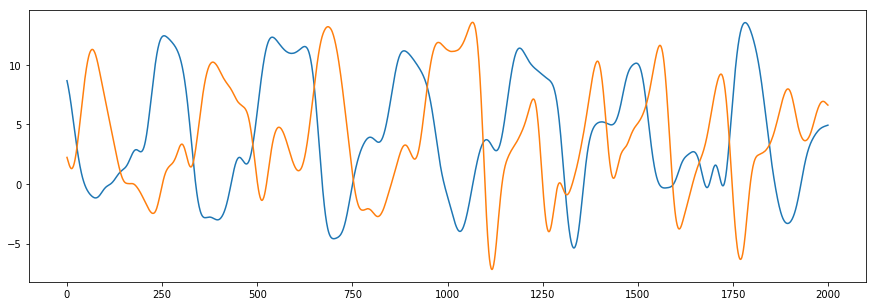

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(gan_502["x"][200000 + 5000:200000 + 7000, 3])
plt.plot(poly["x"][200000 + 5000:200000 + 7000, 3])

#plt.plot(gan_102["x"][200000:210000, 0])

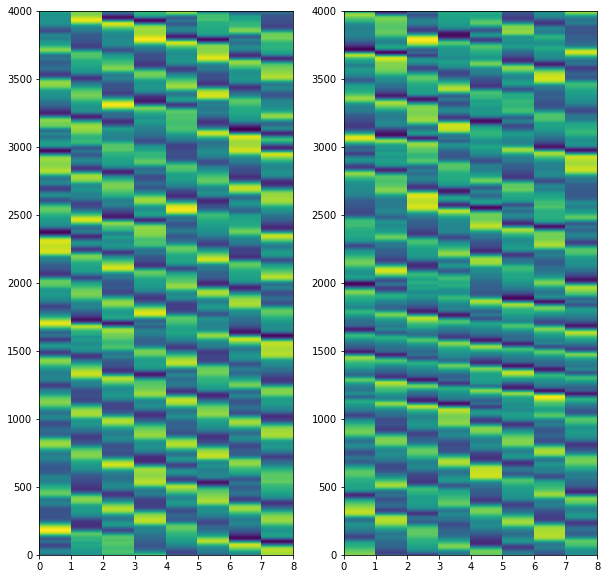

In [50]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.pcolormesh(gan_502["x"][200000 + 5000:200000 + 9000])
plt.subplot(1, 2,2)
plt.pcolormesh(poly["x"][200000 + 5000:200000 + 9000])

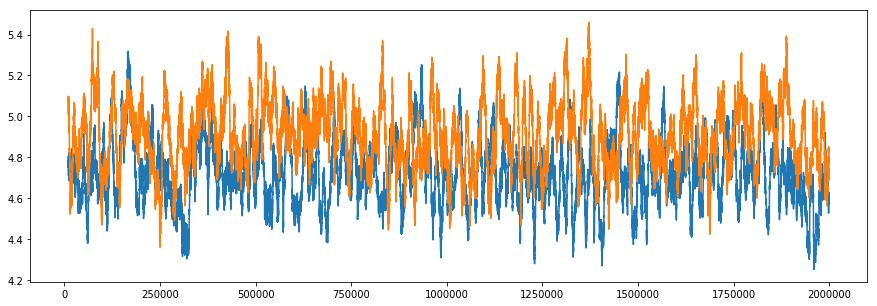

In [61]:
plt.figure(figsize=(15, 5))
plt.plot(pd.Series(gan_502["x"][:, 0]).rolling(10000).std())
plt.plot(pd.Series(poly["x"][:, 0]).rolling(10000).std())


In [5]:
start_index = 2000000
step_values = truth["step"].values
time_values = truth["time"].values

l_start = np.where(step_values == start_index)[0][0]
l_end = l_start + 2000000
truth["lorenz_x"][l_start:l_end, 0].shape

(2000000,)

In [6]:
widths = np.arange(1, 17)
wavelets = np.zeros((len(gan_index), widths.size, gan_ds[500]["x"].shape[0]))
for g, gi in enumerate(gan_index):
    wavelets[g] = cwt(gan_ds[gi]["x"][:, 0], ricker, 2 ** widths)
wout_poly = cwt(poly["x"][:, 0], ricker, 2 ** widths)
wout_truth = cwt(truth["lorenz_x"][l_start:l_end, 0], ricker, 2 ** widths)

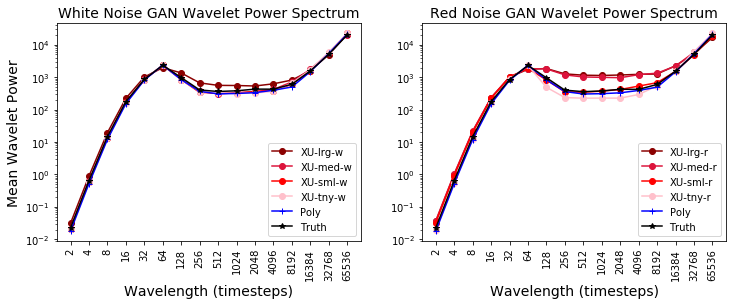

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
colors =["darkred", "crimson", "red", "pink"]
gan_configs = ["XU-lrg-w", "XU-med-w","XU-sml-w", "XU-tny-w", "XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r"]
for i in range(4):
    plt.plot(widths, np.mean(wavelets[i] ** 2, axis=1), marker='o', color=colors[i], label=gan_configs[i])
plt.plot(widths, np.mean(wout_poly ** 2, axis=1), marker='+', color="blue", label="Poly")
plt.plot(widths, np.mean(wout_truth ** 2, axis=1), marker='*', color='k', label="Truth")

plt.xticks(widths, 2 ** widths, rotation=90)
plt.legend()
plt.gca().set_yscale("log")
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.ylabel("Mean Wavelet Power", fontsize=14)
plt.title("White Noise GAN Wavelet Power Spectrum", fontsize=14)
plt.subplot(1, 2, 2)
for i in range(4, 8):
    plt.plot(widths, np.mean(wavelets[i] ** 2, axis=1), marker='o', color=colors[i-4], label=gan_configs[i])
plt.plot(widths, np.mean(wout_poly ** 2, axis=1), marker='+', color="blue", label="Poly")
plt.plot(widths, np.mean(wout_truth ** 2, axis=1), marker='*', color='k', label="Truth")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.gca().set_yscale("log")

plt.title("Red Noise GAN Wavelet Power Spectrum", fontsize=14)
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.savefig("gan_climate_wavelet_power.pdf", bbox_inches="tight")
plt.savefig("gan_climate_wavelet_power.png", dpi=200, bbox_inches="tight")

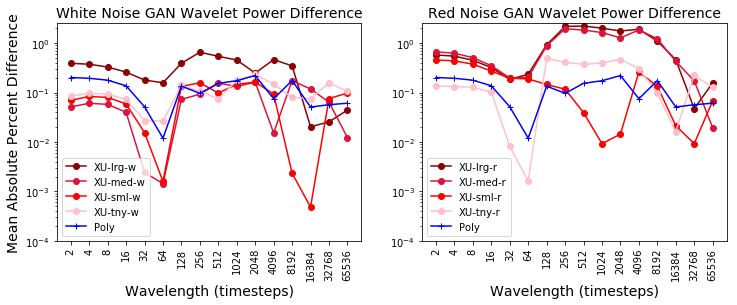

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
colors =["darkred", "crimson", "red", "pink"]
gan_configs = ["XU-lrg-w", "XU-med-w","XU-sml-w", "XU-tny-w", "XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r"]
truth_power = np.mean(wout_truth ** 2, axis=1)
for i in range(4):
    plt.plot(widths, np.abs(np.mean(wavelets[i] ** 2, axis=1) - truth_power) / truth_power, marker='o', color=colors[i], label=gan_configs[i])
plt.plot(widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, marker='+', color="blue", label="Poly")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.ylim(0.0001, 2.5)
plt.gca().set_yscale("log")
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.ylabel("Mean Absolute Percent Difference", fontsize=14)
plt.title("White Noise GAN Wavelet Power Difference", fontsize=14)
plt.subplot(1, 2, 2)
for i in range(4, 8):
    plt.plot(widths, np.abs((np.mean(wavelets[i] ** 2, axis=1) - truth_power)) / truth_power, marker='o', color=colors[i-4], label=gan_configs[i])
plt.plot(widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, marker='+', color="blue", label="Poly")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.ylim(0.0001, 2.5)
plt.gca().set_yscale("log")
plt.title("Red Noise GAN Wavelet Power Difference", fontsize=14)
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.savefig("gan_climate_wavelet_power_diff.pdf", bbox_inches="tight")
plt.savefig("gan_climate_wavelet_power_diff.png", dpi=200, bbox_inches="tight")

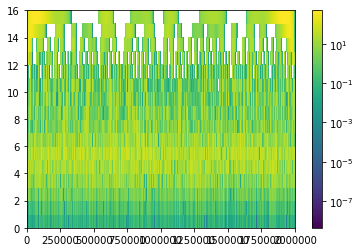

In [34]:
plt.pcolormesh(wout_truth, norm=LogNorm())
plt.colorbar()

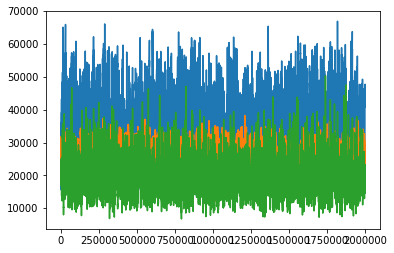

In [119]:
plt.plot(pd.Series(np.abs(wout_gan_302[5])).rolling(1000).sum())
plt.plot(pd.Series(np.abs(wout_gan_302[4])).rolling(1000).sum())
plt.plot(pd.Series(np.abs(wout_gan_302[6])).rolling(1000).sum())

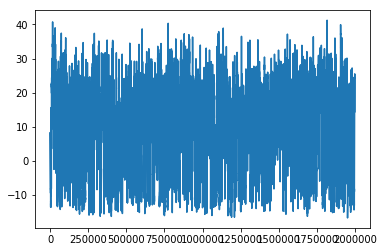

In [124]:
plt.plot(pd.Series(np.abs(wout_gan_302[5]) - np.abs(wout_gan_302[4])).rolling(1000).mean())
